In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import numpy as np
from datetime import datetime, timedelta
import math
import json
from collections import Counter

In [104]:
stats = pd.read_json('stats/LoadTestSession1/User1/stats.json')

index_kurento_names = [
    "loadtest-webrtc-2024-kurento-8p"
]

index_list_names = index_kurento_names

seconds_per_fragment = 17

start_end_times = pd.read_json("dfs_final/start-end-times.json", orient="index")
start_end_times["from"] = pd.to_datetime(
    start_end_times["from"], format="ISO8601", utc=True
).dt.tz_convert("UTC")
start_end_times["to"] = pd.to_datetime(
    start_end_times["to"], format="ISO8601", utc=True
).dt.tz_convert("UTC")


def timestamp_to_secs(df_node, index, timestamp="@timestamp", cpu_times=True):
    df_tmp = df_node.copy()
    df_tmp[timestamp] = pd.to_datetime(df_tmp[timestamp], format="ISO8601")
    end_time = pd.to_datetime(start_end_times.loc[index, "to"])
    df_tmp = df_tmp[df_tmp[timestamp] < end_time]
    start_time = pd.to_datetime(start_end_times.loc[index, "from"])
    df_tmp["timestamp_secs"] = (df_tmp[timestamp] - start_time).dt.total_seconds()
    df_tmp = df_tmp[df_tmp["timestamp_secs"] >= 0]
    return df_tmp


In [105]:
df_user_join_list = [
    pd.read_csv(f"dfs_final/{x}-user-join.csv")
    if os.path.isfile(f"dfs_final/{x}-user-join.csv")
    else pd.DataFrame()
    for x in index_list_names
]

df_cpu_list = [
    pd.read_csv(f"dfs_final/{x}-medianode.csv")
    if os.path.isfile(f"dfs_final/{x}-medianode.csv")
    else pd.DataFrame()
    for x in index_list_names
]

for i, df_user in enumerate(df_user_join_list):
    if not df_user.empty:
        index = index_list_names[i]
        start_test_time = start_end_times.loc[index, "from"]

        df_user["@timestamp"] = pd.to_datetime(df_user["@timestamp"], format="ISO8601")

In [106]:
typologies = ["8p"]
media_nodes = ["kurento"]

data = []
for typology in typologies:
    for media_node in media_nodes:
        target_names = filter(
            lambda x: typology in x and media_node in x, index_list_names
        )
        for i, target_name in enumerate(target_names):
            user_join = pd.read_csv(f"dfs_final/{target_name}-user-join.csv")
            data.append({
                "typology": typology,
                "media_node": media_node,
                "users": len(user_join),
                "publishers": user_join["publishers"].max(),
                "subscribers": user_join["subscribers"].max(),
                "streams in": user_join["streams_in"].max(),
                "streams out": user_join["streams_out"].max(),
                "streams total": user_join["streams_in"].max() + user_join["streams_out"].max(),
            })

data = pd.DataFrame(data)
display(data)
data = data.sort_values(by=["media_node", "typology"])
display(data)

,typology,media_node,users,publishers,subscribers,streams in,streams out,streams total
0,8p,kurento,23,23,0,46,896,942


,typology,media_node,users,publishers,subscribers,streams in,streams out,streams total
0,8p,kurento,23,23,0,46,896,942


In [107]:
stats.head()

,webrtcStats,timestamp,user,session
0,"[{'event': 'getUserMedia', 'tag': 'getUserMedi...",2024-05-20 11:02:54.009000+00:00,User1,LoadTestSession1
1,"[{'event': 'onconnectionstatechange', 'tag': '...",2024-05-20 11:02:56.009000+00:00,User1,LoadTestSession1
2,"[{'event': 'stats', 'tag': 'stats', 'peerId': ...",2024-05-20 11:02:58.009000+00:00,User1,LoadTestSession1
3,"[{'statsSamples': {}}, {'statsSamples': {}}, {...",2024-05-20 11:03:00.011000+00:00,User1,LoadTestSession1
4,"[{'event': 'stats', 'tag': 'stats', 'peerId': ...",2024-05-20 11:03:02.012000+00:00,User1,LoadTestSession1


In [108]:
# each element in the webrtcStats column is a JSON array of JSONs
# for each JSON, there is a webrtcStats property that is a JSON array of JSONs
# for each JSON, there is an event property that is a string
# we want to count the number of times each event type occurs

def extract_events(row):
    events = []
    webrtc_stats_list = row['webrtcStats']
    for item in webrtc_stats_list:
        if 'event' in item:
            events.append(item['event'])
    return events

# Apply the function to each row and collect all events
all_events = []
for index, row in stats.iterrows():
    all_events.extend(extract_events(row))

# Count the occurrences of each event
event_counts = Counter(all_events)

# Convert the Counter to a DataFrame for better visualization
event_counts_df = pd.DataFrame(event_counts.items(), columns=['event', 'count'])

display(event_counts_df)

,event,count
0,getUserMedia,4
1,addConnection,8
2,onnegotiationneeded,1
3,onsignalingstatechange,2
4,onicegatheringstatechange,2
5,onicecandidate,44
6,oniceconnectionstatechange,6
7,onconnectionstatechange,6
8,stats,2396


In [109]:
stats_events = []
for index, row in stats.iterrows():
    webrtc_stats_list = row['webrtcStats']
    for item in webrtc_stats_list:
        if 'event' in item:
            if item['event'] == 'stats':
                stats_events.append(item)

df = pd.DataFrame(stats_events)
display(df.head())


,event,tag,peerId,connectionId,timeTaken,data,timestamp
0,stats,stats,User1,9dc1f1e4-47a5-4133-9606-1485e94afe64,2,"{'audio': {'inbound': [], 'outbound': []}, 'vi...",2024-05-20T11:02:54.456Z
1,stats,stats,User1,9dc1f1e4-47a5-4133-9606-1485e94afe64,1,"{'audio': {'inbound': [], 'outbound': []}, 'vi...",2024-05-20T11:02:55.454Z
2,stats,stats,User1,9dc1f1e4-47a5-4133-9606-1485e94afe64,1,"{'audio': {'inbound': [], 'outbound': [{'id': ...",2024-05-20T11:02:56.460Z
3,stats,stats,User3,str_CAM_Ilui_con_LNa0vP0RBr,1,"{'audio': {'inbound': [{'id': '31fd2c56', 'tim...",2024-05-20T11:02:56.460Z
4,stats,stats,User2,str_CAM_VaE1_con_KPGvgPTcxN,1,"{'audio': {'inbound': [{'id': '4c6b3d5c', 'tim...",2024-05-20T11:02:56.460Z


In [110]:
df["data"]
normalized_qos = pd.json_normalize(df["data"])
# add df["peerId"] to normalized_qos
normalized_qos["peerId"] = df["peerId"]
display(normalized_qos.head())

,audio.inbound,audio.outbound,video.inbound,video.outbound,connection.id,connection.timestamp,connection.type,connection.bytesReceived,connection.bytesSent,connection.lastPacketReceivedTimestamp,...,connection.remote.address,connection.remote.candidateType,connection.remote.port,connection.remote.priority,connection.remote.protocol,remote.audio.inbound,remote.audio.outbound,remote.video.inbound,remote.video.outbound,peerId
0,[],[],[],[],f939d7f,1716202974452,candidate-pair,1581,781,1716202974012,...,44.222.156.75,srflx,57660,1679819007,udp,[],[],[],[],User1
1,[],[],[],[],f939d7f,1716202975452,candidate-pair,1581,781,1716202974012,...,44.222.156.75,srflx,57660,1679819007,udp,[],[],[],[],User1
2,[],"[{'id': 'b143fef8', 'timestamp': 1716202976453...",[],"[{'id': 'b463852f', 'timestamp': 1716202976453...",f939d7f,1716202976452,candidate-pair,2017,46371,1716202976381,...,44.222.156.75,srflx,57660,1679819007,udp,"[{'id': 'ac4d141', 'timestamp': 1716202976026,...",[],"[{'id': '69da8138', 'timestamp': 1716202976380...",[],User1
3,"[{'id': '31fd2c56', 'timestamp': 1716202976454...",[],"[{'id': '6b70a3d0', 'timestamp': 1716202976454...",[],a6f6d96b,1716202976454,candidate-pair,57216,847,1716202976444,...,44.222.156.75,srflx,44220,1679819263,udp,[],"[{'id': 'dce510b9', 'timestamp': 1716202976298...",[],"[{'id': 'b2651e98', 'timestamp': 1716202976175...",User3
4,"[{'id': '4c6b3d5c', 'timestamp': 1716202976455...",[],"[{'id': 'b67b1972', 'timestamp': 1716202976455...",[],8b7b2dab,1716202976455,candidate-pair,44420,893,1716202976444,...,44.222.156.75,srflx,44866,1679819263,udp,[],"[{'id': '3c60e2a7', 'timestamp': 1716202976158...",[],"[{'id': 'd773639f', 'timestamp': 1716202976199...",User2


In [111]:
#remove all entries where audio.inbound is an empty list
def not_empty_list(x):
    return x != []
normalized_inbound = normalized_qos[normalized_qos["audio.inbound"].apply(not_empty_list)]

# keep only audio.inbound, video.inbound, remote.audio.outbound, remote.video.outbound and peerID
normalized_inbound = normalized_inbound[["audio.inbound", "video.inbound", "remote.audio.outbound", "remote.video.outbound", "peerId"]]

def expand_column(df, column_name):
    expanded = df[column_name].apply(pd.Series).stack().reset_index(level=1, drop=True)
    expanded = pd.json_normalize(expanded)
    return expanded

audio_inbound = expand_column(normalized_inbound, "audio.inbound")
video_inbound = expand_column(normalized_inbound, "video.inbound")
remote_audio_outbound = expand_column(normalized_inbound, "remote.audio.outbound")
remote_video_outbound = expand_column(normalized_inbound, "remote.video.outbound")

In [112]:
plt_audio_inbound = audio_inbound.loc[:, ["timestamp", "packetRate", "bitrate"]]
plt_audio_inbound["timestamp"] = pd.to_datetime(plt_audio_inbound["timestamp"], unit="ms")

user_join = df_user_join_list[0]
user_join["@timestamp"] = pd.to_datetime(user_join["@timestamp"], format="ISO8601").dt.tz_localize(None)

cpu = df_cpu_list[0]
cpu = cpu.drop(columns=["memory"]).dropna()
cpu["@timestamp"] = pd.to_datetime(cpu["@timestamp"], format="ISO8601").dt.tz_localize(None)

# here min_ts is calculated as the minimum datetime of the 3 dataframes
# user_join and cpu are time aware while plt_audio_inbound is not
min_ts = pd.concat([cpu["@timestamp"], user_join["@timestamp"], plt_audio_inbound["timestamp"]]).min()

cpu_td = pd.DataFrame(columns=["timestamp", "cpu"])
user_td = pd.DataFrame(columns=["timestamp", "publishers"])

cpu_td["timestamp"] = (cpu["@timestamp"] - min_ts).dt.total_seconds()
cpu_td["cpu"] = cpu["cpu"]

user_td["timestamp"] = (user_join["@timestamp"] - min_ts).dt.total_seconds()
user_td["publishers"] = user_join["publishers"]

plt_audio_inbound["timestamp"] = (plt_audio_inbound["timestamp"] - min_ts).dt.total_seconds()

Text(0.5, 0.98, 'Inbound audio bitrate over time')

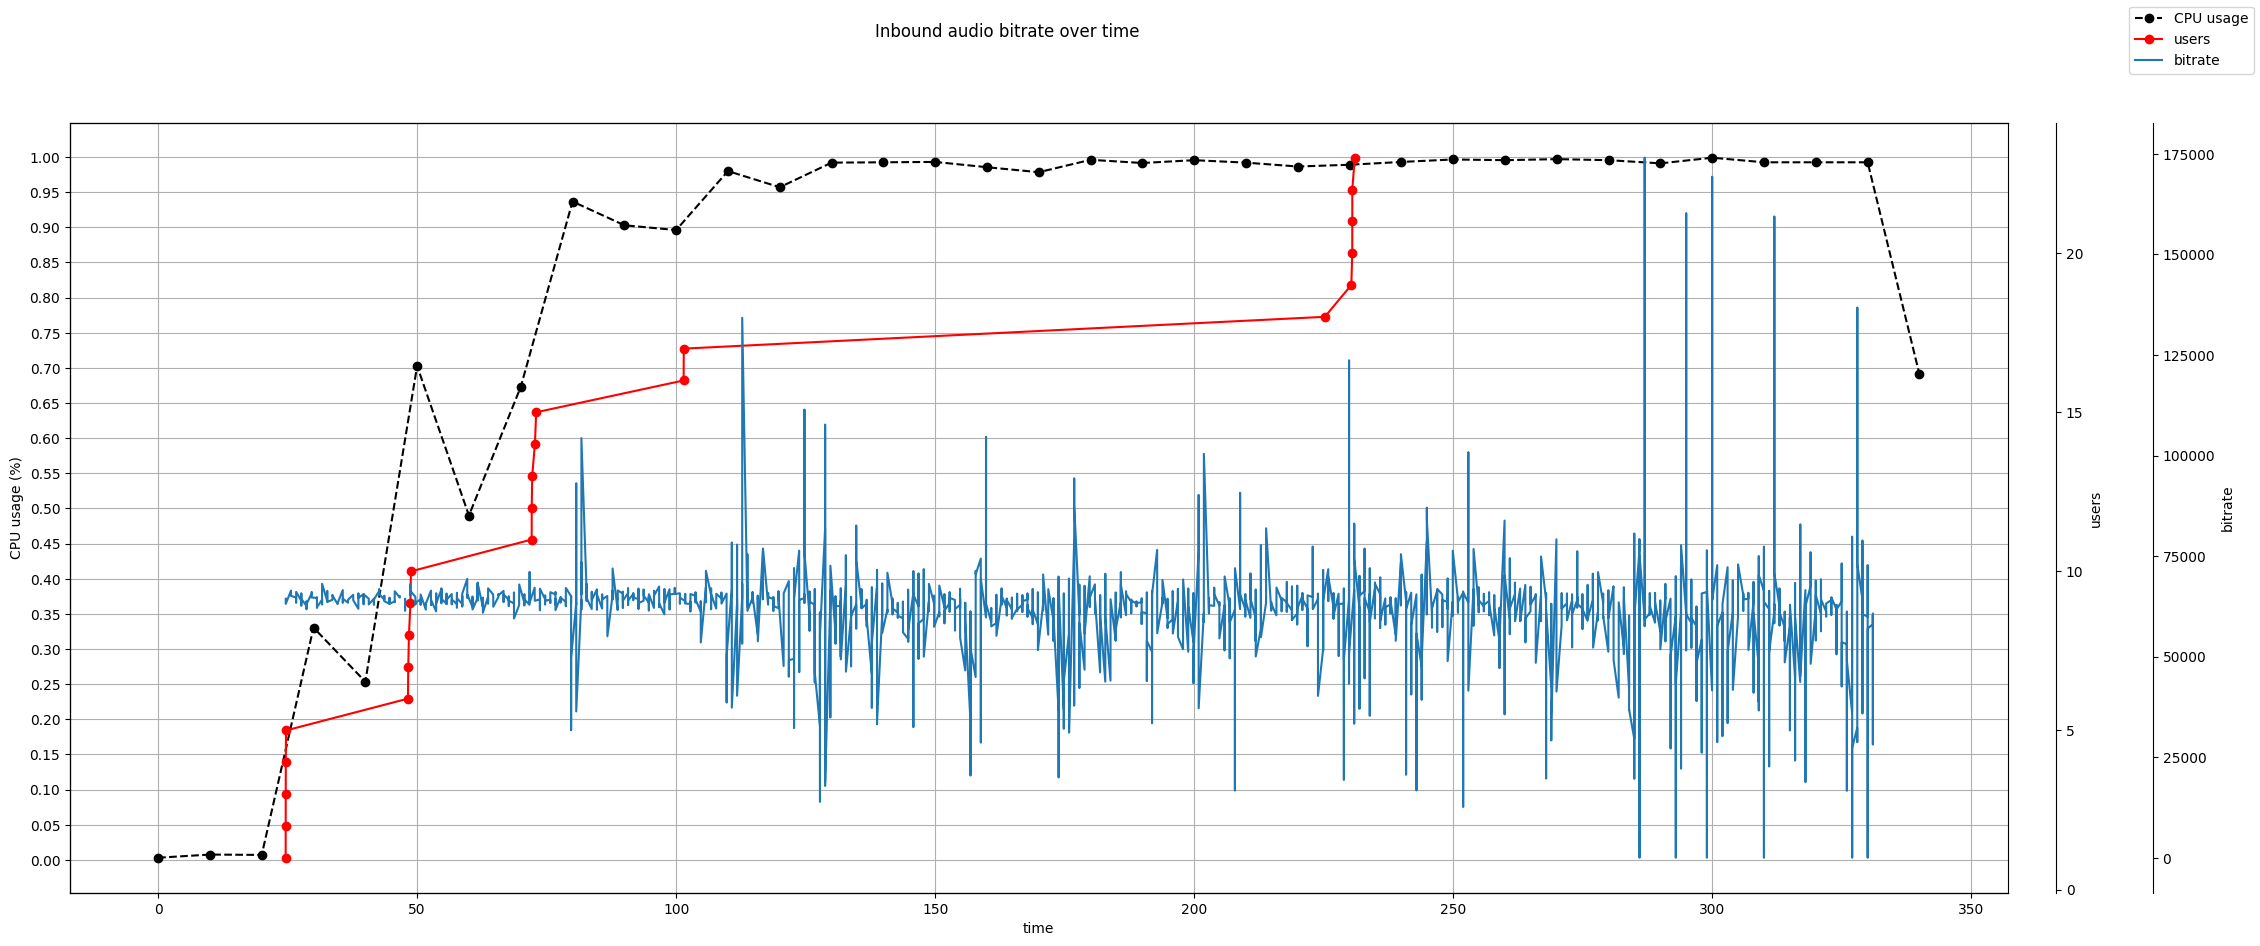

In [113]:
plt.rcParams["figure.figsize"] = [25, 10]

fig, ax = plt.subplots()
ax.plot(cpu_td["timestamp"], cpu_td["cpu"], label="CPU usage", color="black", marker="o", linestyle="--")
ax.set_xlabel("time")
ax.set_ylabel("CPU usage (%)")
ax.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2 = ax.twinx()
ax2.set_ylabel("users")
ax2.spines["right"].set_position(("axes", 1.025))
ax2.plot(user_td["timestamp"], user_td["publishers"], label="users", color="red", marker="o", linestyle="-")
ax3 = ax.twinx()
ax3.set_ylabel("bitrate")
ax3.spines["right"].set_position(("axes", 1.075))
ax3.plot(plt_audio_inbound["timestamp"], plt_audio_inbound["bitrate"], label="bitrate", linestyle="-")

fig.legend()
fig.suptitle("Inbound audio bitrate over time")

Text(0.5, 0.98, 'Inbound audio rate over time')

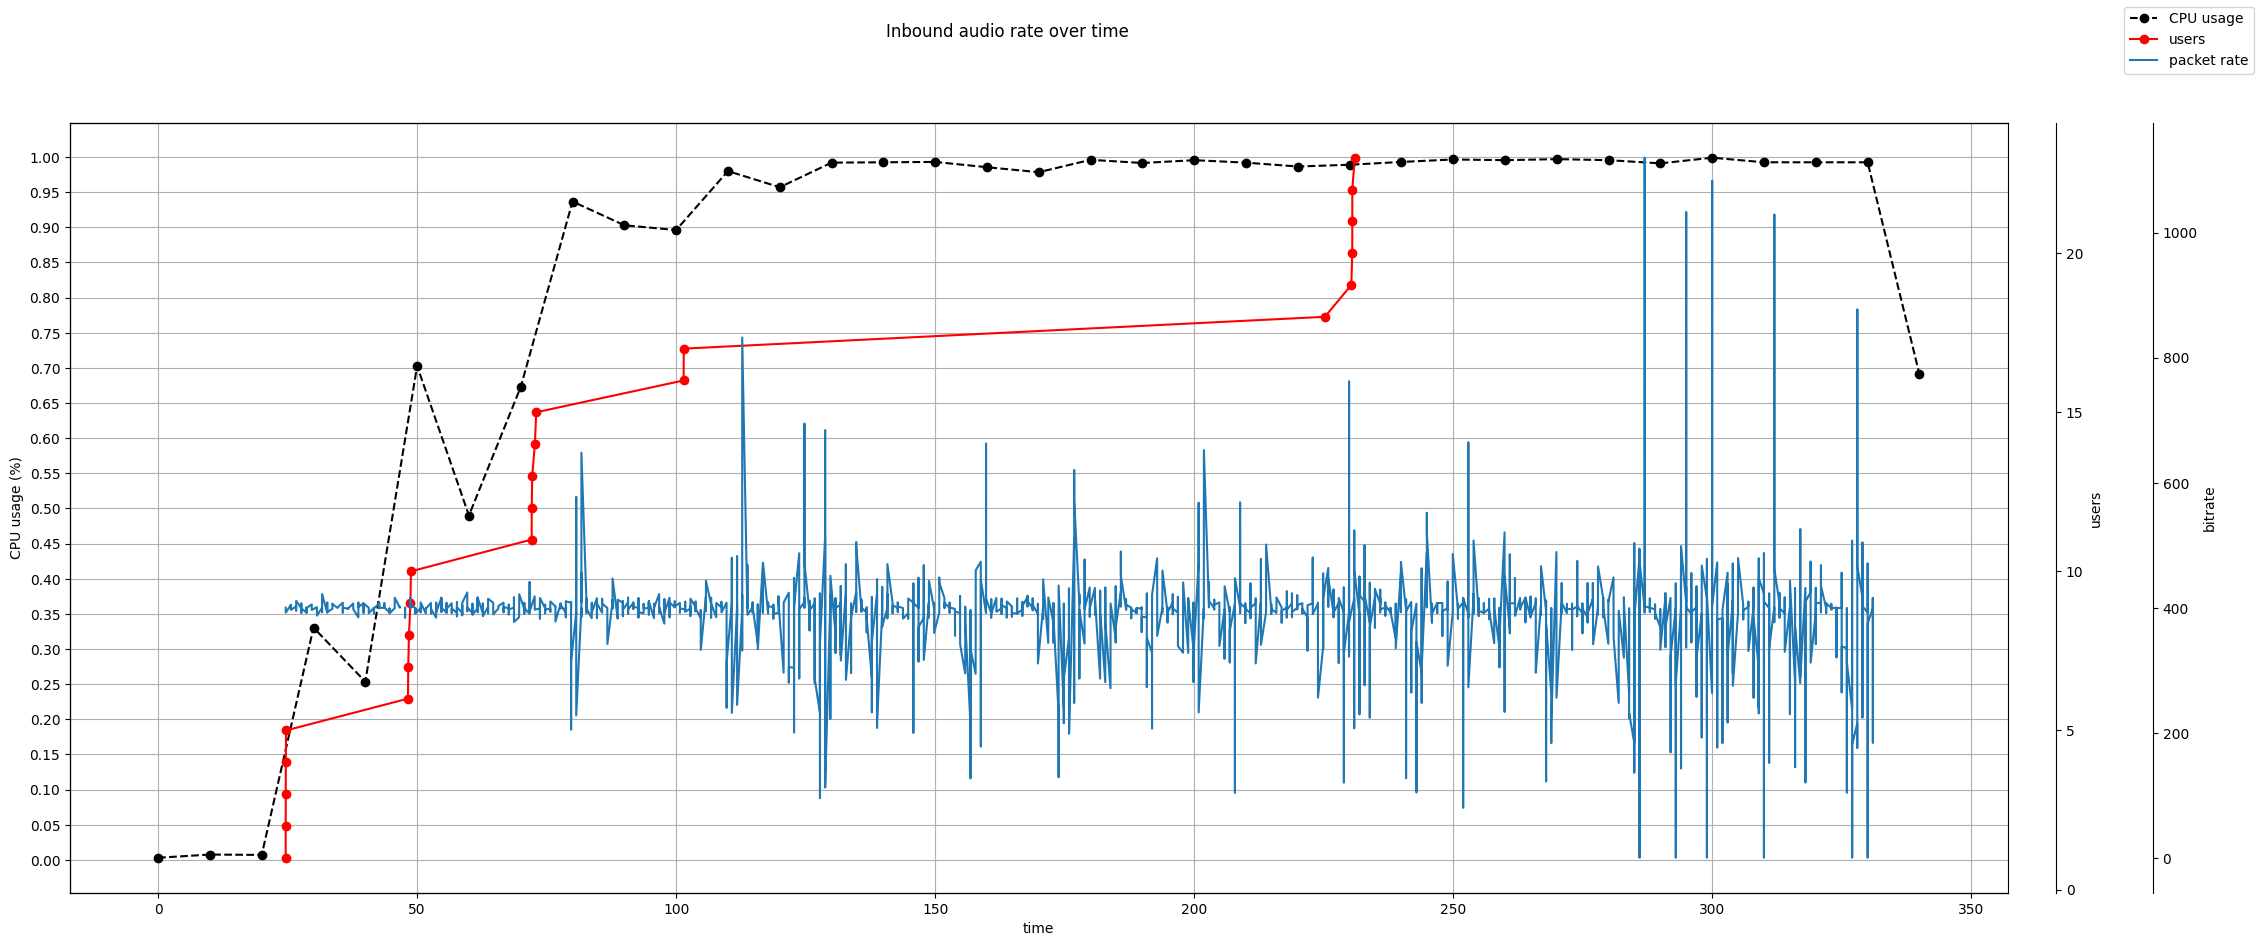

In [114]:
plt.rcParams["figure.figsize"] = [25, 10]

fig, ax = plt.subplots()
ax.plot(cpu_td["timestamp"], cpu_td["cpu"], label="CPU usage", color="black", marker="o", linestyle="--")
ax.set_xlabel("time")
ax.set_ylabel("CPU usage (%)")
ax.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2 = ax.twinx()
ax2.set_ylabel("users")
ax2.spines["right"].set_position(("axes", 1.025))
ax2.plot(user_td["timestamp"], user_td["publishers"], label="users", color="red", marker="o", linestyle="-")
ax3 = ax.twinx()
ax3.set_ylabel("bitrate")
ax3.spines["right"].set_position(("axes", 1.075))
ax3.plot(plt_audio_inbound["timestamp"], plt_audio_inbound["packetRate"], label="packet rate", linestyle="-")

fig.legend()
fig.suptitle("Inbound audio rate over time")

In [115]:
#remove all entries where audio.inbound is an empty list
def not_empty_list(x):
    return x != []
normalized_outbound = normalized_qos[normalized_qos["audio.outbound"].apply(not_empty_list)]

# keep only audio.inbound, video.inbound, remote.audio.outbound, remote.video.outbound and peerID
normalized_outbound = normalized_outbound[["audio.outbound", "video.outbound", "remote.audio.inbound", "remote.video.inbound", "peerId"]]

def expand_column(df, column_name):
    expanded = df[column_name].apply(pd.Series).stack().reset_index(level=1, drop=True)
    expanded = pd.json_normalize(expanded)
    return expanded

audio_outbound = expand_column(normalized_outbound, "audio.outbound")
video_outbound = expand_column(normalized_outbound, "video.outbound")
remote_audio_inbound = expand_column(normalized_outbound, "remote.audio.inbound")
remote_video_inbound = expand_column(normalized_outbound, "remote.video.inbound")

In [116]:
plt_remote_audio_inbound = remote_audio_inbound.loc[:, ["timestamp", "roundTripTime"]]
plt_remote_audio_inbound["timestamp"] = pd.to_datetime(plt_remote_audio_inbound["timestamp"], unit="ms")

min_ts = pd.concat([cpu["@timestamp"], user_join["@timestamp"], plt_remote_audio_inbound["timestamp"]]).min()

cpu_td["timestamp"] = (cpu["@timestamp"] - min_ts).dt.total_seconds()

user_td["timestamp"] = (user_join["@timestamp"] - min_ts).dt.total_seconds()

plt_remote_audio_inbound["timestamp"] = (plt_remote_audio_inbound["timestamp"] - min_ts).dt.total_seconds()

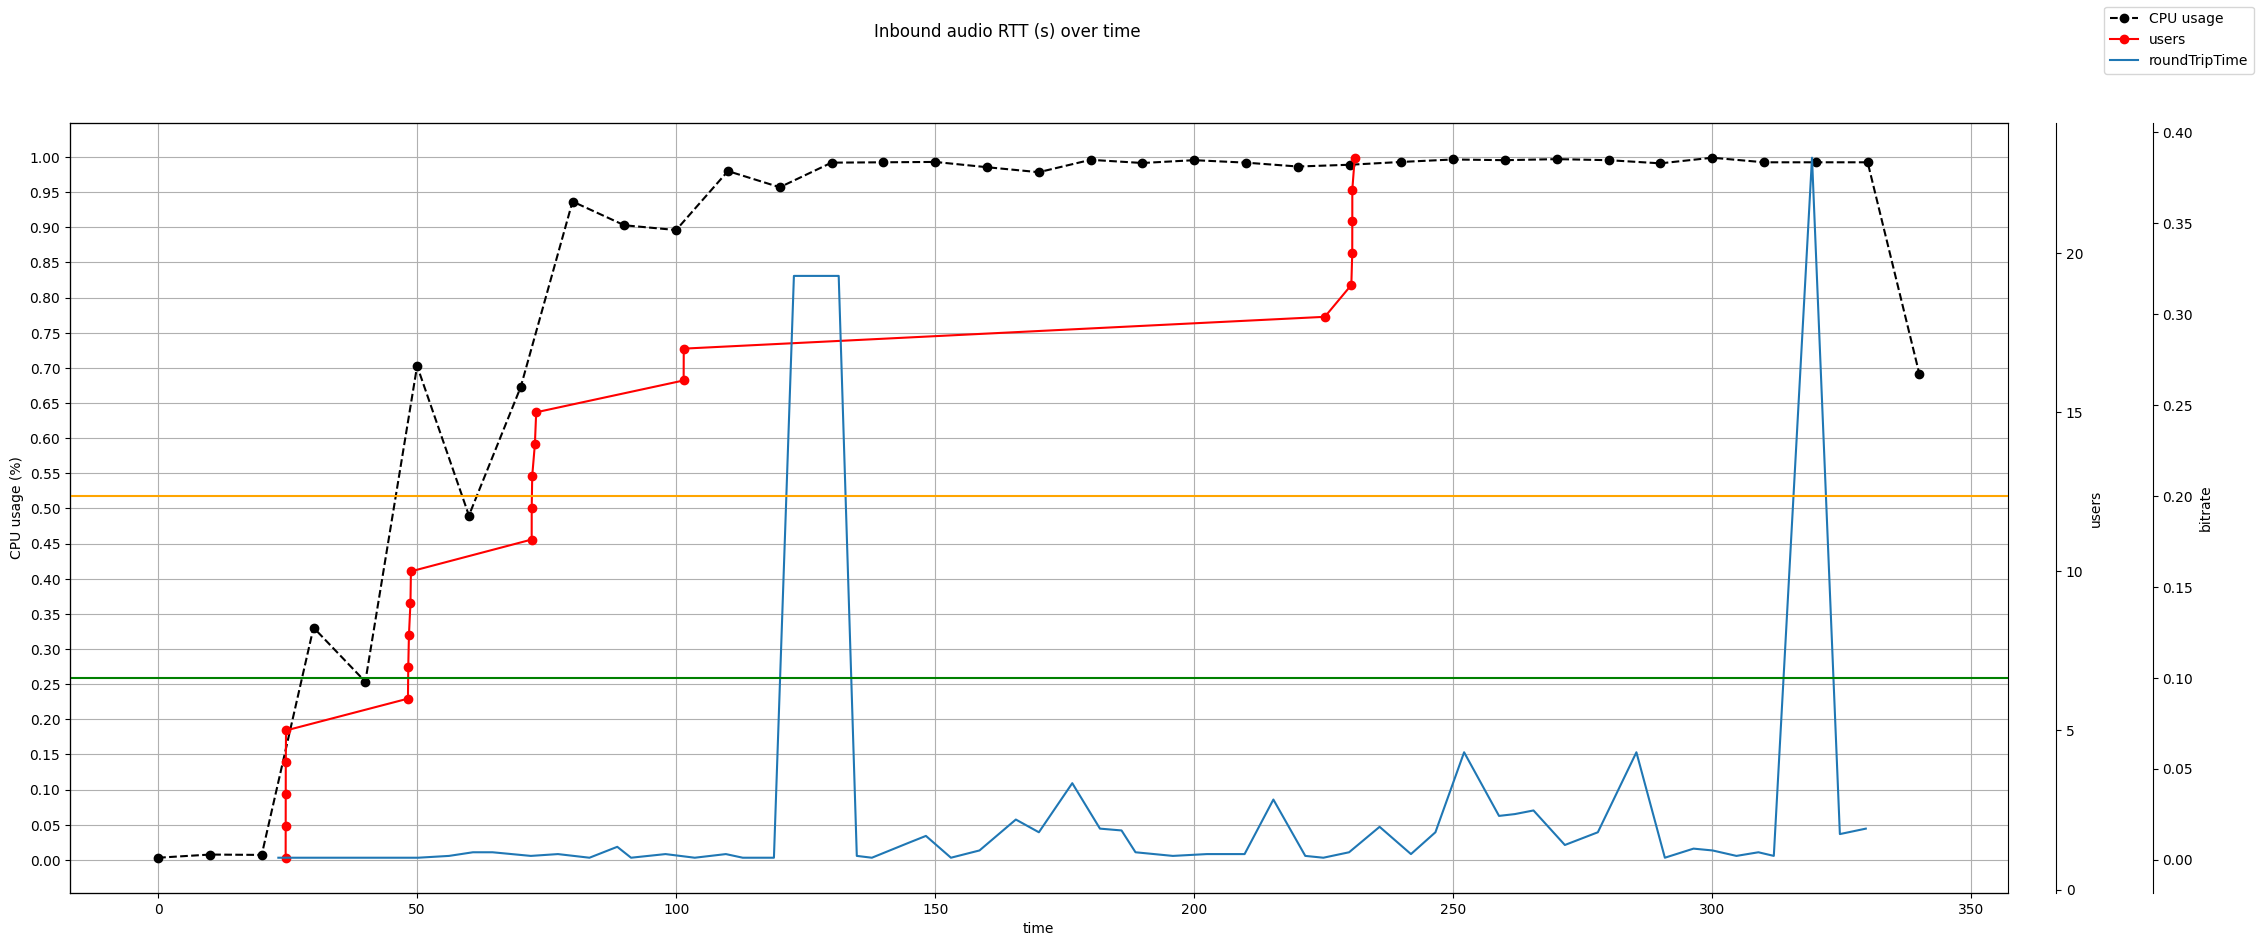

In [117]:
plt.rcParams["figure.figsize"] = [25, 10]

fig, ax = plt.subplots()
ax.plot(cpu_td["timestamp"], cpu_td["cpu"], label="CPU usage", color="black", marker="o", linestyle="--")
ax.set_xlabel("time")
ax.set_ylabel("CPU usage (%)")
ax.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2 = ax.twinx()
ax2.set_ylabel("users")
ax2.spines["right"].set_position(("axes", 1.025))
ax2.plot(user_td["timestamp"], user_td["publishers"], label="users", color="red", marker="o", linestyle="-")
ax3 = ax.twinx()
ax3.set_ylabel("bitrate")
ax3.spines["right"].set_position(("axes", 1.075))
ax3.plot(plt_remote_audio_inbound["timestamp"], plt_remote_audio_inbound["roundTripTime"], label="roundTripTime", linestyle="-")

fig.legend()
fig.suptitle("Inbound audio RTT (s) over time")

ax3.axhline(y=0.1, color="green", linestyle="-", label="good rtt")
ax3.axhline(y=0.2, color="orange", linestyle="-", label="mediocre rtt")

In [118]:
# list of directories in stats/
dirs = os.listdir("stats/")
# read all events.json in each subdir
events = []
for i, dir in enumerate(dirs):
    subdirs = os.listdir(f"stats/{dir}")
    for subdir in subdirs:
        with open(f"stats/{dir}/{subdir}/events.json") as f:
            events.extend(json.load(f))

No stream created for connection User5-LoadTestSession3
No stream created for connection User6-LoadTestSession3
No stream created for connection User7-LoadTestSession3
No stream created for connection User8-LoadTestSession3


Text(0.5, 0.98, 'Time to publish for each connection (s)')

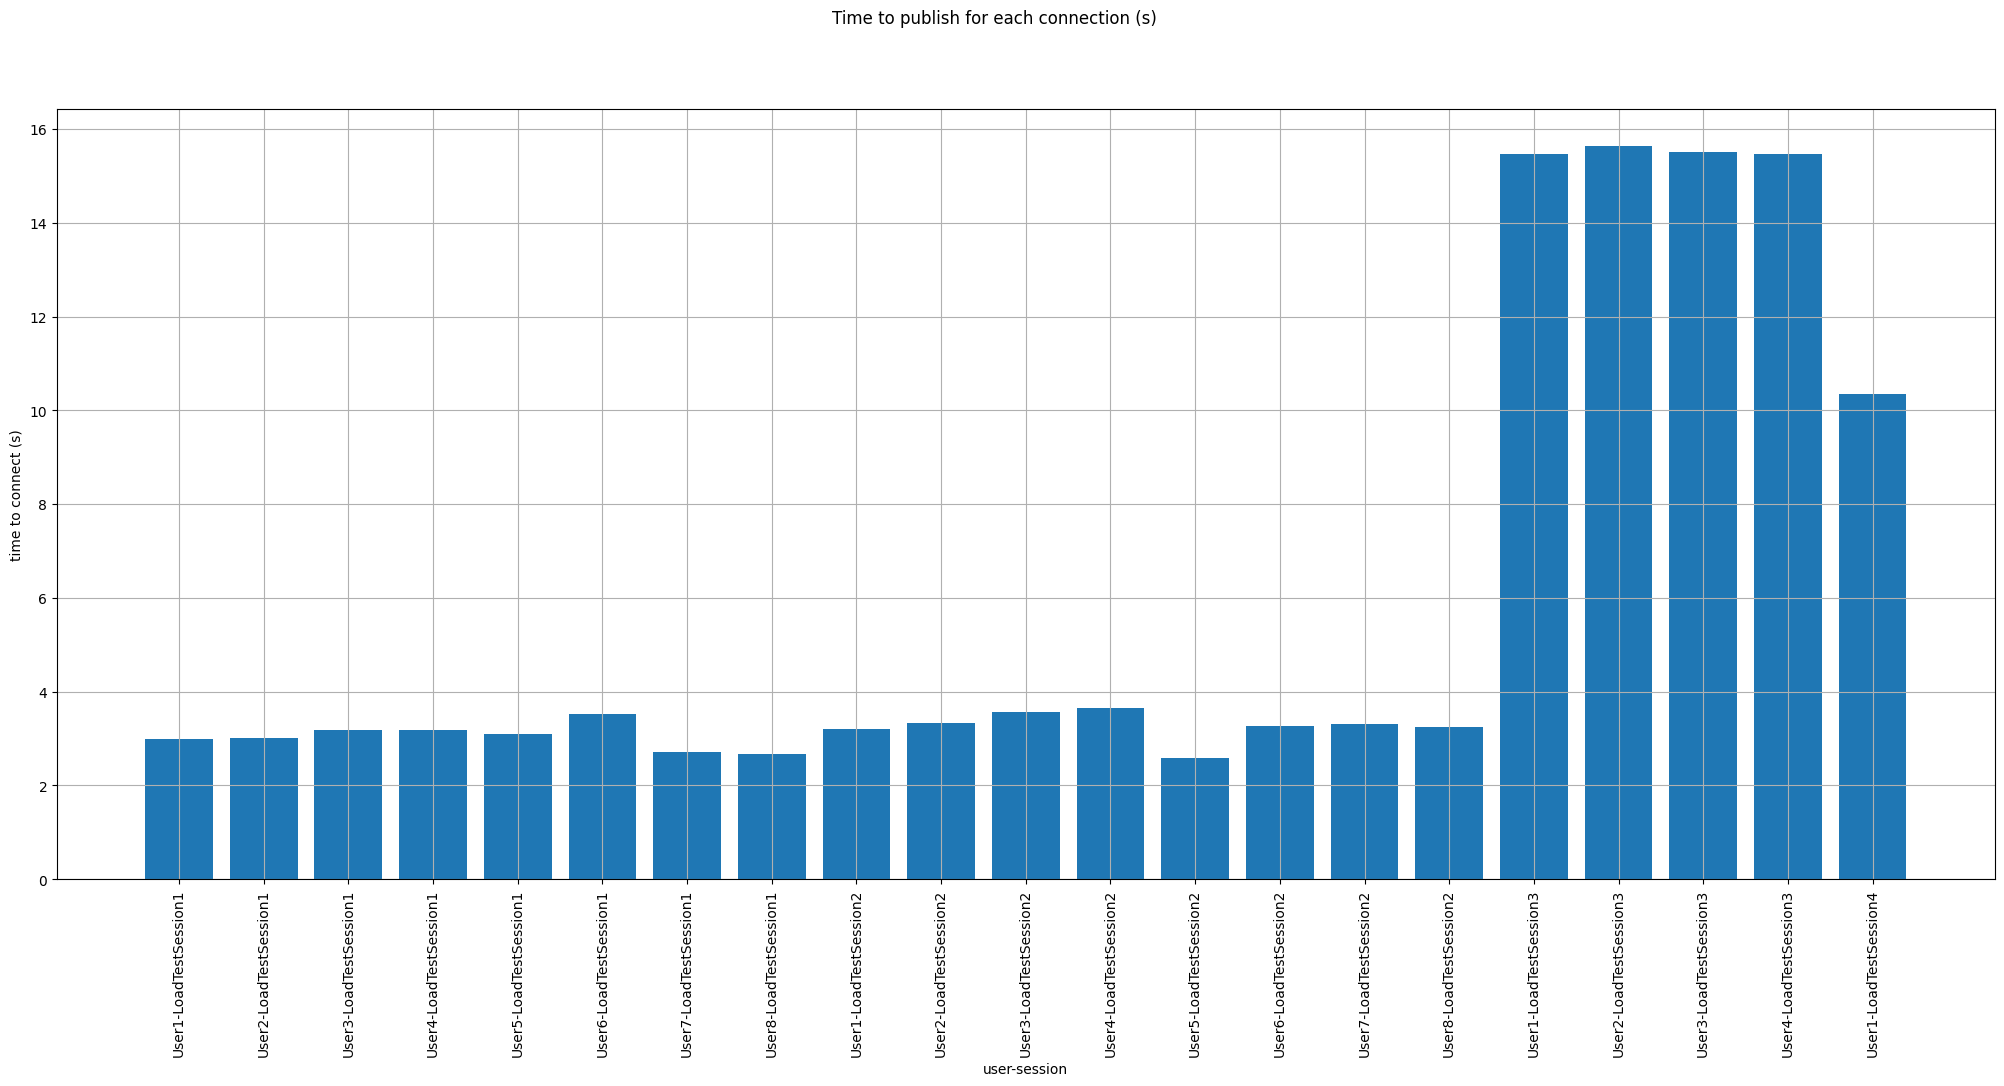

In [119]:
connection_start_fn = lambda x: (x['event'] == 'connectionStart')
connection = list(filter(connection_start_fn, events))

connection_df = pd.DataFrame(columns=["user", "session", "time to connect (s)", "connection start time", "stream created time"])
for i, conn in enumerate(connection):
    participant = conn['participant']
    session = conn['session']
    connection_start = conn['timestamp']
    stream_created = list(filter(lambda x: (x['event'] == 'streamCreated') and (x['connection'] == 'local') and (x['participant'] == participant) and (x['session'] == session), events))
    if len(stream_created) > 1:
        print(f"More than one stream created for connection {participant}-{session}")
    if len(stream_created) == 0:
        print(f"No stream created for connection {participant}-{session}")
        continue
    created_time = stream_created[0]['timestamp']
    # convert to datetime
    connection_start = datetime.strptime(connection_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    created_time = datetime.strptime(created_time, '%Y-%m-%dT%H:%M:%S.%fZ')
    time_diff = (created_time - connection_start).total_seconds()
    connection_df.loc[i] = [participant, session, time_diff, connection_start, created_time]

#display(connection_df)

#bar chart of time to connect
plt.rcParams["figure.figsize"] = [25, 10]
fig, ax = plt.subplots()
ax.bar(connection_df["user"] + "-"+ connection_df["session"], connection_df["time to connect (s)"])
ax.set_xlabel("user-session")
ax.set_ylabel("time to connect (s)")
# rotate x labels
plt.xticks(rotation=90)

ax.grid()
fig.suptitle("Time to publish for each connection (s)")